In [1]:
import xarray as xr
import numpy as np
from scipy import ndimage
import skimage as skimage
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from scipy.interpolate import spline,BSpline

In [2]:
#Import simulation
path = '/project/s916/davidle/RCE-MIP/simulations/RCE_300_3km_206x206/' #Path for Daint

In [3]:
#Read Data
#d2D = xr.open_mfdataset(path+'output/lfff????????.nc', combine='by_coords')
d2D = xr.open_mfdataset(path+'output/lfff9?00????.nc', combine='by_coords')

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [62]:
def get_contours(bFMSE, minLength = 35):
    #INPUT: binary field
    
    contours = (skimage.measure.find_contours(bFMSE[:,:], 0))

    #Remove small contours
    index = 0
    idx = []
    for c in range(len(contours)):
        if len(contours[c][:]) < minLength:
            idx.append(index)
        index+=1

    return np.delete(contours, idx, axis=0)

In [102]:
def calc_curv(x, y, dx = 3300):

    # determine equally spaced points along the contour
    
    xd = np.diff(x)
    yd = np.diff(y)
    dist = np.sqrt(xd**2+yd**2)
    u = np.cumsum(dist)
    u = np.hstack([[0],u])

    #TODO: Running or Bsplines
    t = np.arange(0,u.max(), 7) # use effective resolution (7 grid spacings)
    xn = np.interp(t, u, x)
    yn = np.interp(t, u, y)
    
    # curvature calculation
    curv = (np.gradient(xn)*np.gradient(np.gradient(yn)) - np.gradient(yn)*np.gradient(np.gradient(xn)))/(np.gradient(xn)**2+np.gradient(yn)**2)**1.5
  
    return xn, yn, curv


In [103]:
def get_extrema(curv, x, y, filter=False):

    #Slightly smooth with Savitzky-Golay filter to get rid of small bends in the curve 
    if filter:
        #TODO: test sensitivity of coefficients
        curv = savgol_filter(curv, 9, 1) 

    #TODO: Replace with np.diff
    #Find local maxima on contour
    maxima = np.r_[True, curv[1:] < curv[:-1]] & np.r_[curv[:-1] < curv[1:], True]

    #Find local minima on contour
    minima = np.r_[True, curv[1:] > curv[:-1]] & np.r_[curv[:-1] > curv[1:], True]

    #In boolean arithmetic: inclusive OR is the same as + operation
    extrema = maxima  + minima
    
    #Remove endpoints
    extrema[0] = False
    extrema[-1]= False

    extremas=curv[np.argwhere(extrema)] #The values of the extrema
    ex = x[np.argwhere(extrema)]
    ey = y[np.argwhere(extrema)]

    return extremas, ex, ey

In [250]:
def distance_of_contour_extremas(FMSE, FMSE_told, dx = 1):

    #Create list of curvature extrema at old timestep
    contours_last = get_contours(FMSE_told)
    

    x_old = np.array([], int)
    y_old = np.array([], int)
    extremas_old = np.array([], int)
    
    for n, contour in enumerate(contours_last):
        x = contour[:, 1]
        y = contour[:, 0]
                
        cx, cy, curv = calc_curv(x, y)

        extrema, ex, ey = get_extrema(curv, cx, cy)

        x_old = np.append(x_old, ex)
        y_old = np.append(y_old, ey)
        extremas_old = np.append(extremas_old, extrema)

  
    #Create list of curvature extrema at new timestep
    contours = get_contours(FMSE)
    x = np.array([], int)
    y = np.array([], int)
    extremas = np.array([], int)
    
    for n, contour in enumerate(contours):
        cx, cy, curv = calc_curv(contour[:, 1], contour[:, 0])
        extrema, ex, ey = get_extrema(curv, cx, cy)
        
        x = np.append(x, ex)
        y = np.append(y, ey)
        extremas = np.append(extremas, extrema)
        
    #Search for the closest matching point
    x_new = np.array([], int)
    y_new = np.array([], int)
    extremas_new = np.array([], int)
    x_corr = np.array([], int)
    y_corr = np.array([], int)
    distances = np.array([], int)

    for n in range(len(x)):
        distance = np.sqrt((x_old-x[n])**2 + (y_old-y[n])**2) #Distance between all the points

        #>
        #Only consider extrema that are closer together than 1/R of curvature
        #if np.min(distance) < 100*np.abs(extremas[n]):
        if np.min(distance) < 10:
            
            #All the point at t, that fulfill the criterion
            x_new = np.append(x_new, x[n])
            y_new = np.append(y_new, y[n])
            extremas_new = np.append(extremas_new , extremas[n])
            
            #Coordinates and distance to closest point
            x_corr = np.append(x_corr, x_old[np.argmin(distance)])
            y_corr = np.append(y_corr, y_old[np.argmin(distance)])
            distances=np.append(distances, np.min(distance))
    
    #Return the values of the extrema their coordinates and the distance between them
    return  extremas_new, x_new, y_new, x_corr, y_corr, distances * dx

In [251]:
#Mask of all moist regions
bFMSE = np.where(d2D.FMSE > np.median(d2D.FMSE, axis=(1,2))[:, np.newaxis, np.newaxis], 1, 0)

[1.         1.         7.7394764  6.2231762  5.5432772  2.77862905
 4.76301286 9.01510277 6.56819198 3.78951048 2.74162876 8.80090019
 4.41969168 5.73951186 8.57843876 3.30589355 2.23606798 1.74822778
 5.03816124 5.68022317 4.04391481 4.584596   7.14142843 4.99044543
 2.64547115]


ValueError: setting an array element with a sequence.

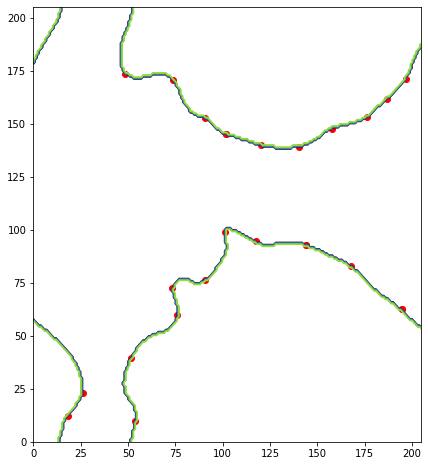

In [269]:
curvature, x, y, x_old, y_old, distance,  = distance_of_contour_extremas(bFMSE[-1,:,:], bFMSE[-2,:,:])
print(distance)

fig = plt.figure(figsize=(32,8))

plt.subplot(1, 4, 1)
plt.contour(bFMSE[-2,:,:])
plt.scatter(x_old,y_old, c = 'r')

for en, extrem in enumerate(curvature):
    circle = plt.Circle((x[en], y[en]), radius = 100 * curvature, facecolor='none', edgecolor='k')
    ax.add_patch(circle)

plt.subplot(1, 4, 2)
plt.contour(bFMSE[-1,:,:])
plt.scatter(x, y, c = 'r')

plt.subplot(1, 4, 3)
plt.scatter( curvature, distance)

    
plt.subplot(1, 4, 4)
for t in range(1,len(bFMSE)):
    curvature, x, y, x_old, y_old, distance,  = distance_of_contour_extremas(bFMSE[t,:,:], bFMSE[t-1,:,:])
    
    plt.subplot(1, 4, 4)
    plt.scatter(curvature, distance)
   


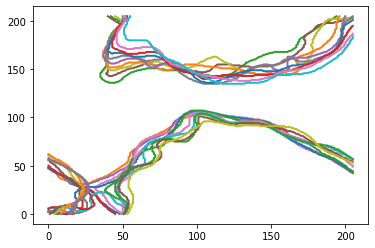

In [242]:
for t in range(len(bFMSE)):
    
    contours = get_contours(bFMSE[t,:,:])
    
    for n, contour in enumerate(contours):
         plt.plot(contour[:, 1], contour[:, 0], linewidth=2)

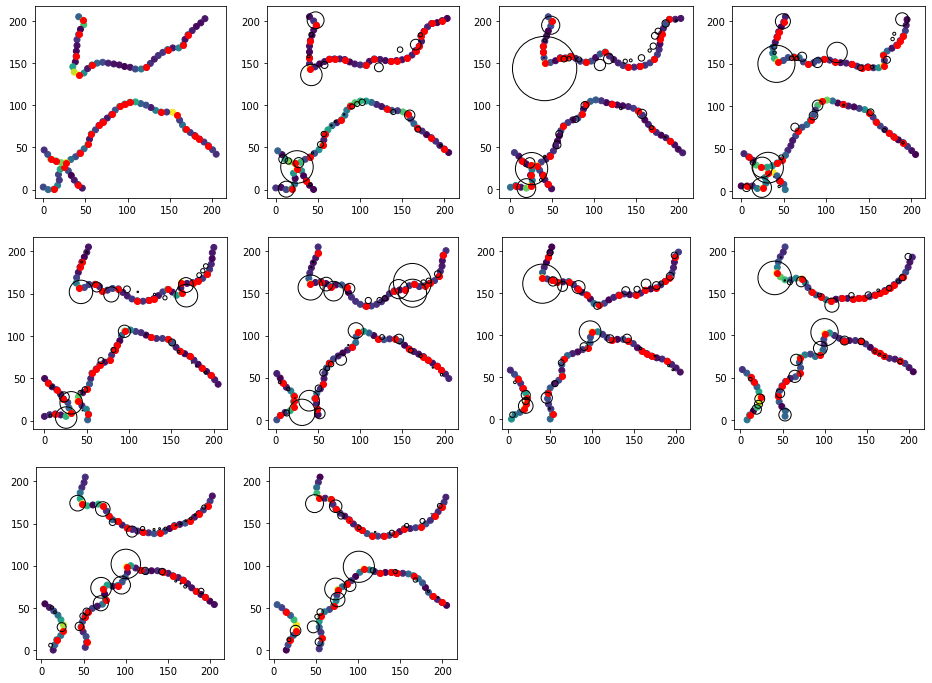

In [197]:
### Plot curvature and local extrema for all contours

fig = plt.figure(figsize=(16,12))
for t in range(len(bFMSE)):
    ax = fig.add_subplot(3,4,t+1)
    ax.set_aspect('equal')

    contours = get_contours(bFMSE[t,:,:])
    contours_last = get_contours(bFMSE[t-1,:,:])

    for n, contour in enumerate(contours):

        #Compute curvature
        x = contour[:, 1]
        y = contour[:, 0]
        xn, yn, curv= calc_curv(x, y)

        #Plot curvature
        ax.scatter(xn, yn, c = np.abs(curv))
    
        #Plot Extrema
        extrema, ex, ey = get_extrema(curv, xn, yn) #Todo: replace by x ,y
        ax.scatter(ex, ey, c = 'r')
    
    #Add circles of extremas of last timestep
    if t > 0:
        for n, contour in enumerate(contours_last):
            cx, cy, curv = calc_curv(contour[:, 1], contour[:, 0])
            extrema, ex, ey= get_extrema(curv, cx, cy)
                
            for en, extrem in enumerate(extrema):
                circle = plt.Circle((ex[en], ey[en]), radius = 100 * extrem, facecolor='none', edgecolor='k')
                ax.add_patch(circle)
              

In [12]:
c_old = skimage.measure.find_contours(bFMSE[-374,:,:,], 0)
x_old = c_old[-1][:, 1]
y_old = c_old[-1][:, 0]
xn_old, yn_old, curv_old = calc_curv(x_old, y_old)

plt.figure(figsize = (5, 5))

for i_t in range(-500, -380, 6): 
     
    c = skimage.measure.find_contours(bFMSE[i_t,:,:,], 0)
    
    contour = c[-1]
    
    x = contour[:, 1]
    y = contour[:, 0]
    
    xn, yn, curv = calc_curv(x, y)
    
    # Determine point of maximal curvature
    
    xn_max = xn[np.argmax(np.abs(curv))]
    yn_max = yn[np.argmax(np.abs(curv))]
    
    # Determine point of minimal distance 
    
    distance = np.sqrt((xn_old-xn_max)**2+(yn_old-yn_max)**2)
    
    xn_max_old, yn_max_old = xn_old[np.argmin(distance)], yn_old[np.argmin(distance)]
    
    xn_old = np.copy(xn)
    yn_old = np.copy(yn)
    
    plt.plot(xn, yn, 'C0', alpha = 0.2)
    plt.scatter(xn_max, yn_max, c = 'r')
    plt.scatter(xn_max_old, yn_max_old, c = 'k')


IndexError: index -374 is out of bounds for axis 0 with size 10

In [ ]:
x = contour[:, 1]
y = contour[:, 0]

In [ ]:
plt.plot((curv))